# Predicting Movie's Box Office Performance: A Supervised Learning Approach

Poomrapee Chuthamsatid, Andrew Flanagan, and Harsh Patel

SENG474 Final Project

Instructor: Dr. Alex Thomo

June 30th, 2023

## Contents

Table of Contents goes here



1.   Introduction
2.   Data Collection
3.   Initial Data Exploration
4.   Exploratory Data Anaylsis and Data Visualization
5.   Feature Extraction & Data Cleaning
6.   Model Selection
7.   Conclusion
8.   Limitations
9.   References





# 1 **Introduction**

Box office revenue is an important indicator of a film's financial success. This information is valuable to production studios and investors that aim to maximize the profits of their films. Although box office success is becoming increasingly less important with the rise of at-home streaming services, a film's box office performance can determine the amount of promotion and marketing a film will receive, and whether the studio wants to pursue sequels or work with the cast and crew on future projects. There are many factors that might contribute to a film's box office success. We hope to uncover aspects of a film that might forecast its theatrical success.


We collected the data using TMDB's (The Movie Database) free API. This API contains various information about a movie such as release date, budget, cast and crew, genre, and various other information. We extracted features from this data that we thought might assist our models in making more accurate predictions.

Predicting box office success will be valuable information to investors and producers in weighing the potential financial success of a film. This information is also likely to be of interest to cinephiles with an interest in box office performance.

Our study was built on the assumption that budget would play a significant role as films with large budgets are typically produced by well-known production companies with a wide range of audiences. In this paper, we will build machine-learning models to address the following research questions regarding box office revenue:


RQ1: Is our assumption about the strong correlation between box office revenue and budget accurate?

RQ2: Apart from the budget, what other factors influence box office revenue?

RQ3: What is the relative importance or weight contribution of
different factors to box office revenue?

RQ4: How well do our models perform in predicting box office revenue on the testing dataset?


To enable the performance comparison, we utilize four different models including linear regression, decision tree, random forest, and XGB regression. We will prepare and input a number of interested attributes from the TMDB data set to explore the relationship among factors. Our ultimate goal is to uncover the correlations among various factors and accurately predict box office revenue.

# 2 Data Collection

Data was collected using TMDB's API. This API posed numerous challenges for this project. Mainly, many of the films in their database do not contain any revenue data. Although we were mainly concerned with finding movies with revenue data, many films returned by the API do not contain other information that we wanted to use such as genres and budget. Additionally, there is limited ability to filter requests by revenue. We considered two possible approaches to collect the data.

## 2.1 TMDB's /discover endpoint

TMDB's /discover endpoint allows for querying of movies using filtering and sorting options. The primary issue with this method is that it does not allow for filtering by revenue. You can however, sort by revenue. The response returns a list of 20 dictionaries that contains information about a movie such as its ID, title, etc. These dictionaries do not contain revenue information. To get revenue data you must then query using the /movie endpoint using the movie's ID. Another parameter, 'page' is what specifies the list of 20 movies.

For example, the following response will contain a list of 20 dictionary items, where each dictionary contains key/value pairs about a movie. This will be the 100th-120th highest earning box office revenue movies.



```
params = {
  sort_by: 'revenue.desc',
  page: 5
}
url = "https://api.themoviedb.org/3/discover/movie"
response = requests(url, params=params)
```

The response will look similar to this, note that to get revenue data you must then query by the 'id' of the movie:



```
{
  "page": 5,
  "results": [
    {
      "adult": false,
      "backdrop_path": "/tqj7NKj11keFuLzPsBDMUq2dOUO.jpg",
      "genre_ids": [
        12,
        14,
        28
      ],
      "id": 120,
      "original_language": "en",
      "original_title": "The Lord of the Rings: The Fellowship of the Ring",
      "overview": "Young hobbit Frodo Baggins, after inheriting a mysterious ring from his uncle Bilbo, must leave his home in order to keep it from falling into the hands of its evil creator. Along the way, a fellowship is formed to protect the ringbearer and make sure that the ring arrives at its final destination: Mt. Doom, the only place where it can be destroyed.",
      "popularity": 99.166,
      "poster_path": "/6oom5QYQ2yQTMJIbnvbkBL9cHo6.jpg",
      "release_date": "2001-12-18",
      "title": "The Lord of the Rings: The Fellowship of the Ring",
      "video": false,
      "vote_average": 8.4,
      "vote_count": 22824
    },
    ...
}
```



The max value that can be passed with the 'page' parameter is 500. This means that we can only query for the top 10,000 highest earning box office films using the /discover endpoint. Initially, we hoped to get at least 5,000 instances for this project, and so we were concerned that sampling 5,000 out of the top 10,000 highest earning box office films would not be very representative of all the films with box office data. The 10,000th film had a revenue value of about 1.6 million whereas the highest earning film had a revenue value of about 2.9 billion.

# 2.2 Randomly Sampling Using TMDB's API and Additional Data

Dissatisfied with the aforementioned method, we decided to try another approach. One method to select a movie with a greater degree of randomness is to query for the latest movie ID. After getting the latest ID we generated a random number with the latest ID as an upper bound. Two issues we ran into were that once again, few movies have revenue data, and many of the IDs have been deleted, so we were getting a lot of 404 responses.

We then discovered that TMDB provides a daily export of valid IDs. This is a file where each line contains a JSON object containing the ID and some limited information about the corresponding movie. This greatly reduced the amount of 404 errors that we encountered. On some preliminary tests we found that from randomly sampling from this file, only about 2-3% of films actually contained revenue data. Thus, with a desired initial dataset of around 10,000, we randomly sampled from this 500,000 times and made requests for each entry, ignoring the film if it did not contain revenue data. Since we were sending so many requests, we had to batch our requests to avoid usage limits set by TMDB. This method provided a greater level of randomness because we were now sampling from all films in TMDB's database, rather than just the top 10,000 highest earning films. We also no longer needed to query within the range of the latest movie ID since the file provided us a list of valid IDs already. The major drawback of this method is the time required to gather all the data.

We chose to use this method to gather data that is more representative of the range of box office performance. We then performed some exploratory data analysis and visualization along with some cleaning of the data.

The following code is used to randomly sample 500,000 IDs from the list of all valid TMDB IDs.

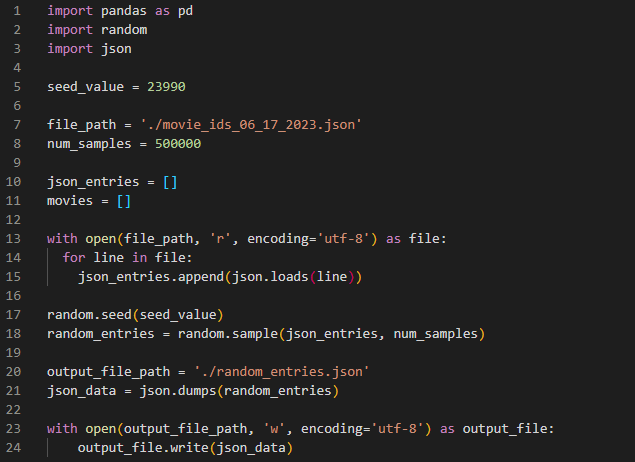

After saving the 500,000 movie entries to a JSON file, we make a request for each entry and check if it has valid revenue data. If it does, we append the details to a list and then save the list as a csv file. The 1,000 minimum is arbitrarily selected to skip entries with possibly invalid data. We will filter out missing values in other attributes later as part of the data cleaning process. The start_index and end_index are used to batch our requests to the API to avoid usage limits and disconnects since this code takes a long time to run.

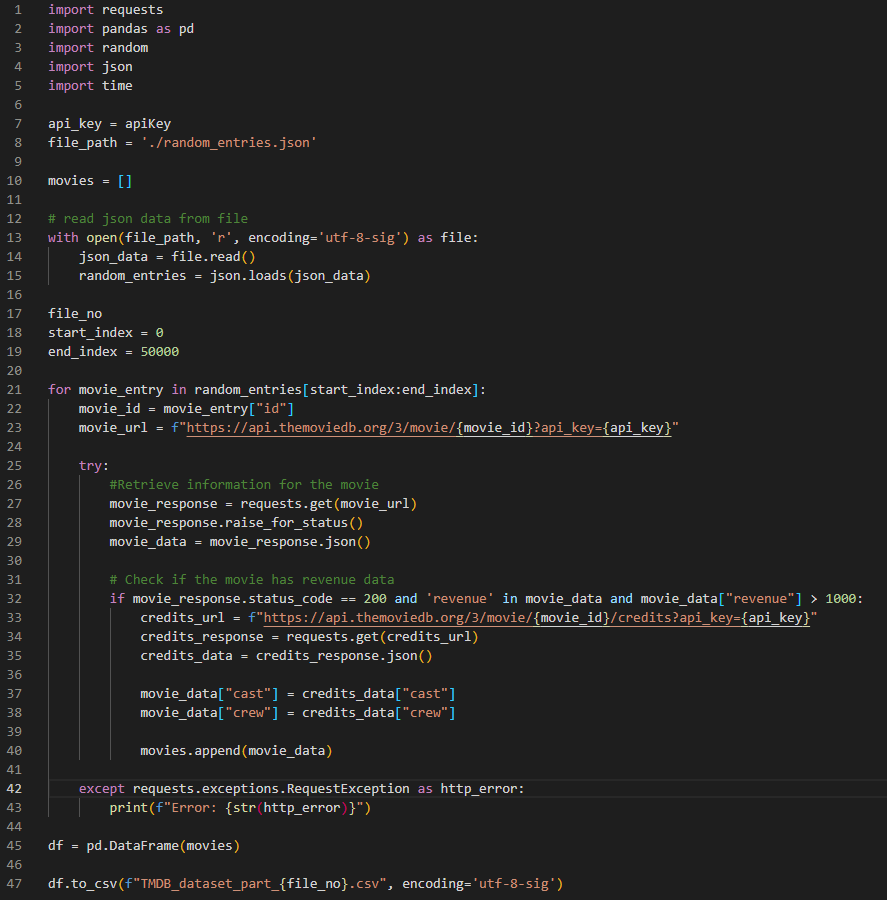

After sending a request and checking revenue data for all 500,000 entries, we concatenate all the csv files into one csv file.

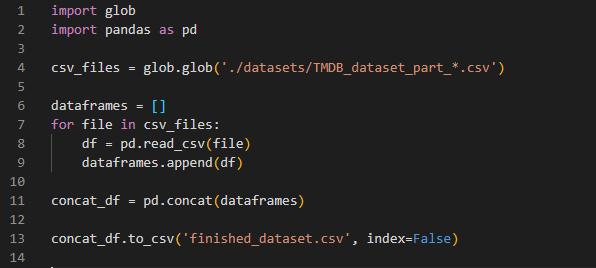

## 3. Initial Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pandas.plotting import scatter_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Read in the data
movies = pd.read_csv("TMDB_movies_dataset.csv", index_col=0)

We will explore what attributes we need to drop.

In [2]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9788 entries, 0 to 946
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9788 non-null   bool   
 1   backdrop_path          8672 non-null   object 
 2   belongs_to_collection  1692 non-null   object 
 3   budget                 9788 non-null   int64  
 4   genres                 9788 non-null   object 
 5   homepage               2953 non-null   object 
 6   id                     9788 non-null   int64  
 7   imdb_id                9375 non-null   object 
 8   original_language      9788 non-null   object 
 9   original_title         9788 non-null   object 
 10  overview               9503 non-null   object 
 11  popularity             9788 non-null   float64
 12  poster_path            9533 non-null   object 
 13  production_companies   9788 non-null   object 
 14  production_countries   9788 non-null   object 
 15  release_da

According to TMDB, the video attribute is for media such as sporting events and live performances, thus we will need to drop any instances that have True for the video attribute.

In [3]:
movies = movies[movies['video'] != True]

We have approximately 9700 instances in our dataset and 27 columns. Notice that there are 1225 movies that belong to a collection. This means that they are part of a series or franchise. This might be useful information, so we will consider extracting this attribute into a usable format for our model later. Many of these attributes look like they will not be relevant for our purposes, so we will drop these columns. Explanations for these attributes can be found [here](https://www.themoviedb.org/bible/movie/59f3b16d9251414f20000001#59f73b759251416e71000005). Although popularity and vote_average would likely be useful metrics for this project, we decided to not use any information that was not available before a movie's release.

In [4]:
drop_cols = ['imdb_id', 'video', 'vote_average', 'vote_count', 'status', 'poster_path', 'popularity', 'id', 'homepage', 'backdrop_path', 'adult', 'original_title', 'title', 'overview', 'tagline']

for col in drop_cols:
  movies.drop(col, axis=1, inplace=True)

Another look at the dataset shows us that we now have 12 columns and most of the instances have data for all the columns. Whether a film belongs to a collection can be treated as a boolean so the missing values are not a concern. There are a couple movies with missing data for release date which we might have to consider.

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9555 entries, 0 to 946
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   belongs_to_collection  1690 non-null   object
 1   budget                 9555 non-null   int64 
 2   genres                 9555 non-null   object
 3   original_language      9555 non-null   object
 4   production_companies   9555 non-null   object
 5   production_countries   9555 non-null   object
 6   release_date           9430 non-null   object
 7   revenue                9555 non-null   int64 
 8   runtime                9555 non-null   int64 
 9   spoken_languages       9555 non-null   object
 10  cast                   9555 non-null   object
 11  crew                   9555 non-null   object
dtypes: int64(3), object(9)
memory usage: 970.4+ KB


We'll need to explore some of these attributes further to see what kind of data is provided by the API.

In [6]:
movies.head()

,belongs_to_collection,budget,genres,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,cast,crew
Unnamed: 0,,,,,,,,,,,,
0,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",en,"[{'id': 54016, 'logo_path': None, 'name': 'Rot...","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-06-06,159429,81,"[{'english_name': 'English', 'iso_639_1': 'en'...","[{'adult': False, 'gender': 1, 'id': 9206, 'kn...","[{'adult': False, 'gender': 1, 'id': 10419, 'k..."
1,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",zh,[],"[{'iso_3166_1': 'CN', 'name': 'China'}]",2015-06-19,47600000,133,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...","[{'adult': False, 'gender': 2, 'id': 99689, 'k...","[{'adult': False, 'gender': 2, 'id': 122171, '..."
2,NaN,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'id': 47261, 'logo_path': None, 'name': 'Pri...","[{'iso_3166_1': 'US', 'name': 'United States o...",2013-02-14,7965,100,"[{'english_name': 'English', 'iso_639_1': 'en'...","[{'adult': False, 'gender': 2, 'id': 83222, 'k...","[{'adult': False, 'gender': 2, 'id': 133664, '..."
3,NaN,15000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",en,"[{'id': 2, 'logo_path': '/wdrCwmRnLFJhEoH8GSfy...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-10-11,19158074,90,"[{'english_name': 'English', 'iso_639_1': 'en'...","[{'adult': False, 'gender': 1, 'id': 6279, 'kn...","[{'adult': False, 'gender': 2, 'id': 2626, 'kn..."
4,"{'id': 126166, 'name': 'The Delta Force Collec...",0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,"[{'id': 1444, 'logo_path': '/1848gsFuV3EGewKg8...","[{'iso_3166_1': 'IL', 'name': 'Israel'}, {'iso...",1986-02-14,17768900,129,"[{'english_name': 'English', 'iso_639_1': 'en'...","[{'adult': False, 'gender': 2, 'id': 51576, 'k...","[{'adult': False, 'gender': 2, 'id': 37, 'know..."


We will also factorize original_language to get it into a usable format for the models.

In [7]:
movies['original_language_num']  = pd.factorize(movies['original_language'])[0]

Some of these attributes such as 'genres' are supposed to be dictionaries, but because the data is in a csv file they are treated as strings. We will need to write a helper function that converts these strings back into a dictionary.

In [8]:
# code modified from: https://www.kaggle.com/code/artgor/eda-feature-engineering-and-model-interpretation

dict_cols = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew']

for col in dict_cols:
    movies[col] = [ast.literal_eval(x) if not pd.isna(x) else {} for x in movies[col]]

Although there are few non-null values, we also want to check for zero values as this is an indication of missing data. We will need to check for null and zero value entries and decide what to do with those attributes. Let's start with release_date.

In [9]:
movies['release_date'].isna().sum()

125

There are 125 missing values for release_date, we can drop these rows.

In [10]:
movies = movies.dropna(subset=['release_date'])

From the data's description we can see that there are some missing values that we will need to filter out or impute. Notice that the min budget and runtime values are 0.00.

In [11]:
pd.set_option('display.float_format', '{:.2f}'.format)

movies.describe()

,budget,revenue,runtime,original_language_num
count,9430.00,9430.00,9430.00,9430.00
mean,14555980.05,43951298.03,102.57,4.54
std,31677031.30,127710866.88,29.79,8.82
min,0.00,1015.00,0.00,0.00
25%,0.00,557023.00,91.00,0.00
50%,1380000.00,5000000.00,101.00,0.00
75%,15000000.00,28932155.25,116.00,7.00
max,460000000.00,2923706026.00,569.00,69.00


In [12]:
movies['budget'].value_counts()

budget
0           3425
20000000     184
5000000      169
25000000     167
10000000     160
            ... 
1791280        1
8330           1
63600000       1
8616269        1
103000         1
Name: count, Length: 1108, dtype: int64

This confirms that a bit more than one third of the films are missing budget data. We attempted to fill this attribute using external data by using Wikipedia's API but very few Wikipedia entries contained budget information for these films.

We want to ensure that all instances have valid data. We will remove rows from the dataframe that have missing values.

In [13]:
# These are numeric columns that might have zero values.
zero_val_cols = ['runtime', 'revenue', 'budget']

# Drop all instances where the value is <= 1
for column in zero_val_cols:
  movies = movies[movies[column] > 1]

# These columns contain a list of dictionary entries.
# We will drop instances that have an empty list for these attributes.
for col in dict_cols[1:]:
  movies = movies[movies[col].apply(len) != 0]

movies = movies.reset_index(drop=True)

In [14]:
movies.shape

(5536, 13)

It looks like we dropped about 4000 rows by filtering out instances with missing values. Although we've lost a lot of data, we collected much more than we needed in anticipation of having to drop much of it. Let's also take another look at the numeric data.

In [15]:
movies.describe()

,budget,revenue,runtime,original_language_num
count,5536.00,5536.00,5536.00,5536.00
mean,24613082.40,68952804.65,108.58,3.32
std,38186946.45,159995451.60,23.11,8.03
min,10.00,1200.00,3.00,0.00
25%,2900000.00,2491856.75,94.00,0.00
50%,10550000.00,14869410.50,105.00,0.00
75%,30000000.00,61838295.00,120.00,0.00
max,460000000.00,2923706026.00,339.00,69.00


Based on the minimum value for runtime, it seems that we also have some short films in our dataset. This might also explain the $10 minimum budget value. We will keep these instances.

Now let's take a look at the data distribution for the numerical attributes.

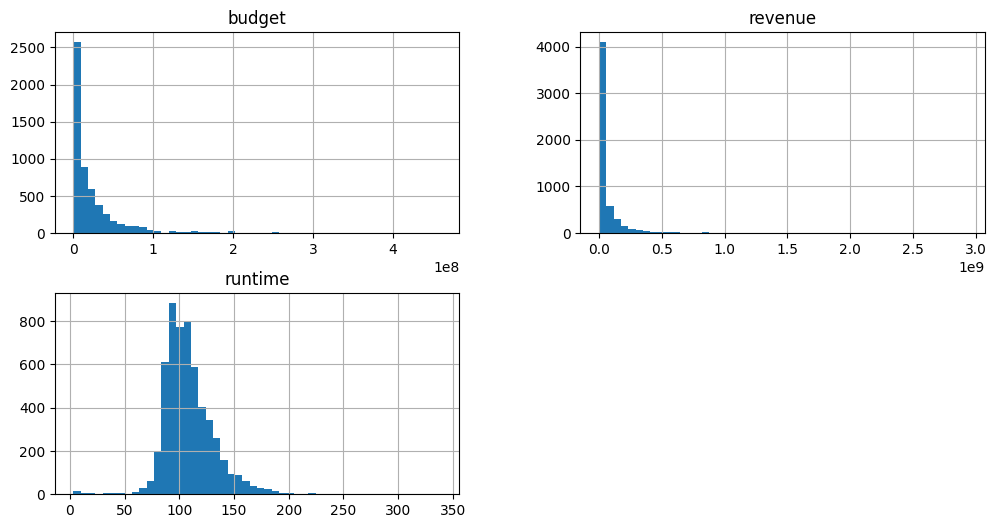

In [16]:
movies[['budget', 'revenue', 'runtime']].hist(bins=50, figsize=(12, 6))
plt.show()


It appears that budget and revenue are heavily right skewed. We will have to apply some transformations to this data before feeding it to our models. Runtime appears to be fairly evenly distributed.




## Create Test and Train Set

From our common-sense, we know that the movie budget is a very important attribute to predict the movie revenue (we later know that the corelation between budget and revenue is very high at 0.74 from corr()). We want to ensure that the test set is representative of the various categories of budget in the dataset. We stratified the samples to reduce a sampling bias. The following code will create a  categories from numberic instance of budget and create a budget category attribute with four categoeies (labeled from 1 to 5) where category 1 ranges from 0 to 1000000, category 2 ranges from 1000000 to 10000000, and so on.

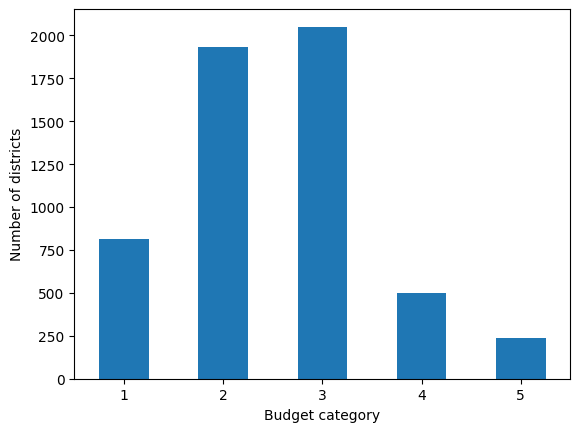

In [17]:
# split bin to set training and testing data set by spliting the revenue data into 4 quartiles
movies["budget_cat"] = pd.cut(movies["budget"], bins=[0, 1000000, 10000000, 50000000, 100000000, np.inf], labels=[1, 2, 3, 4, 5])
movies["budget_cat"].value_counts().sort_index().plot.bar(rot=0)

plt.xlabel("Budget category")
plt.ylabel("Number of districts")
plt.show()

We split the dataset into training and testing sets by using stratified sampling based on the budget category. The ratio size is 80:20 percent on training and testing datasets respectively.

In [18]:
train_set, test_set = train_test_split(movies, test_size=0.2, stratify=movies["budget_cat"], random_state=42)

print(train_set.shape, test_set.shape)

(4428, 14) (1108, 14)


We can drop the budget_cat column now that we've used it for stratified sampling.

In [19]:
test_set.drop("budget_cat", axis=1, inplace=True)
train_set.drop("budget_cat", axis=1, inplace=True)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4428 entries, 212 to 4916
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   belongs_to_collection  4428 non-null   object
 1   budget                 4428 non-null   int64 
 2   genres                 4428 non-null   object
 3   original_language      4428 non-null   object
 4   production_companies   4428 non-null   object
 5   production_countries   4428 non-null   object
 6   release_date           4428 non-null   object
 7   revenue                4428 non-null   int64 
 8   runtime                4428 non-null   int64 
 9   spoken_languages       4428 non-null   object
 10  cast                   4428 non-null   object
 11  crew                   4428 non-null   object
 12  original_language_num  4428 non-null   int64 
dtypes: int64(4), object(9)
memory usage: 484.3+ KB


# 4. Exploratory Data Anaylsis and Data Visualization

Put the test set aside and only explore the training set.


In [20]:
train_movies = train_set.copy()
test_movies = test_set.copy()

The correlation coeﬀicient ranges from –1 to 1. When the number is close to 1, it indicates a strong positive correlation. When the number is close to -1, it indicates a strong negative correlation. When the number is close to 0, it indicates no linear correlation. Look for numeric catagories' correlations.

<Axes: >

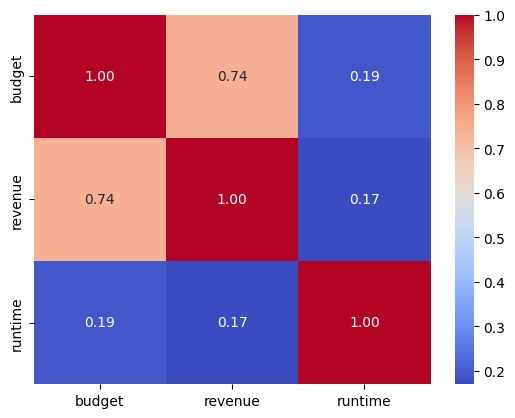

In [21]:
selected_columns = ['budget', 'revenue', 'runtime']
num_movies = train_movies[selected_columns].select_dtypes(include=[np.number])
corr = num_movies.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")

We can see that the budget is highly corelated to the revenue with value of 0.74. However, the runtime has a weak impact on the revenue with mere 0.17.

array([[<Axes: xlabel='budget', ylabel='budget'>,
        <Axes: xlabel='revenue', ylabel='budget'>,
        <Axes: xlabel='runtime', ylabel='budget'>,
        <Axes: xlabel='original_language_num', ylabel='budget'>],
       [<Axes: xlabel='budget', ylabel='revenue'>,
        <Axes: xlabel='revenue', ylabel='revenue'>,
        <Axes: xlabel='runtime', ylabel='revenue'>,
        <Axes: xlabel='original_language_num', ylabel='revenue'>],
       [<Axes: xlabel='budget', ylabel='runtime'>,
        <Axes: xlabel='revenue', ylabel='runtime'>,
        <Axes: xlabel='runtime', ylabel='runtime'>,
        <Axes: xlabel='original_language_num', ylabel='runtime'>],
       [<Axes: xlabel='budget', ylabel='original_language_num'>,
        <Axes: xlabel='revenue', ylabel='original_language_num'>,
        <Axes: xlabel='runtime', ylabel='original_language_num'>,
        <Axes: xlabel='original_language_num', ylabel='original_language_num'>]],
      dtype=object)

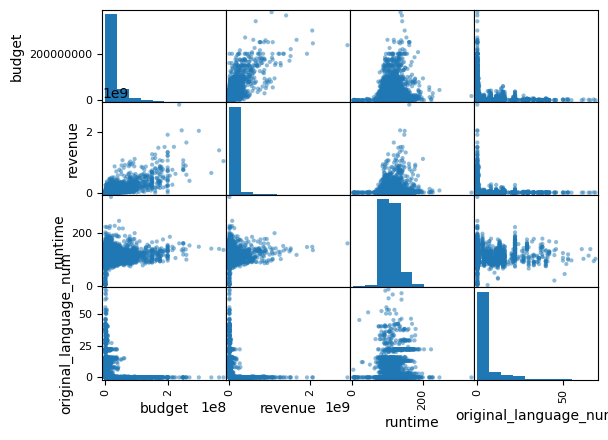

In [22]:
scatter_matrix(train_movies)

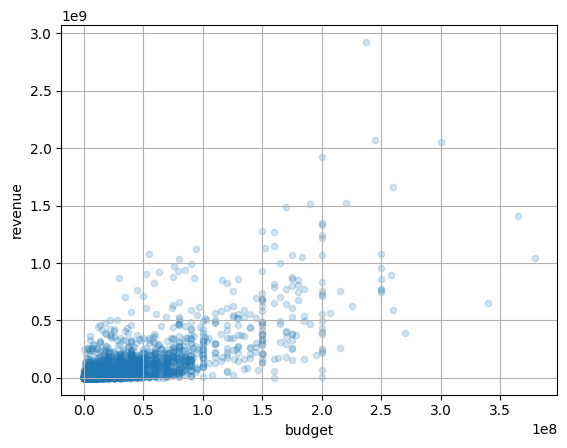

In [23]:
# visualize the correlation between the budget and revenue
train_movies.plot(kind="scatter", x="budget", y="revenue", alpha=0.2, grid=True)
plt.show()

This plot reveal a few things. First, the correlation between revenue and budget is found. As the the budget increases, the revenue tends to go up. Second, the upward trends moment is vary depend on other factors. Thirdly, not every movie with high budget produces a film with high revenue.

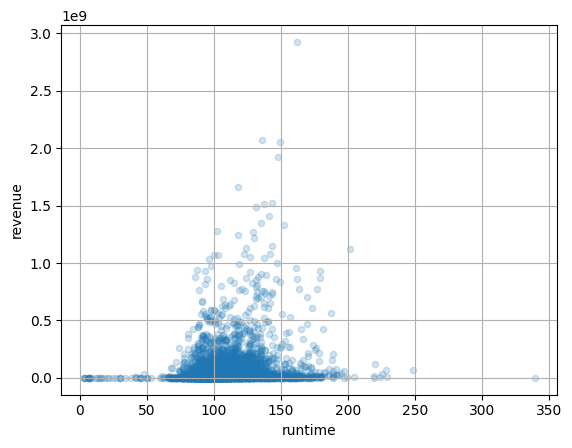

In [24]:
# visualize the correlation between the runtime and revenue
train_movies.plot(kind="scatter", x="runtime", y="revenue", alpha=0.2, grid=True)
plt.show()

This plot illustrate a few thing. First, the majority of high revenue movie has a runtime between 90 to 180 minutes. Second, there are a few outliers where the runtime is close to 0 and one very long movie around 350 minutes long. We can see that there is not a noticeable linear relationship.

## 4.1 Prepare the Data for Machine Learning

### Target Variable

We can see that the revenue is a high exponential right-skew distribution. We can obtain normal distribution by applying log1p.

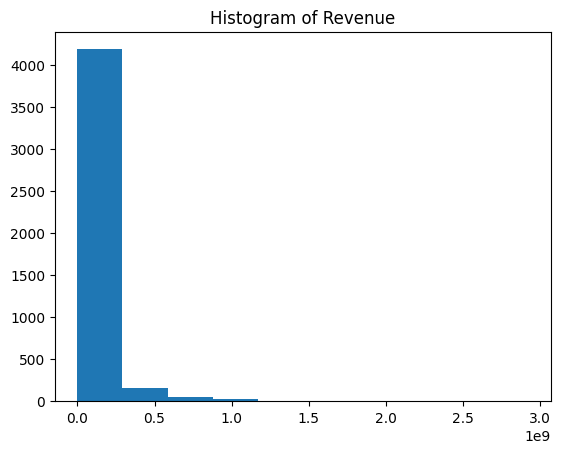

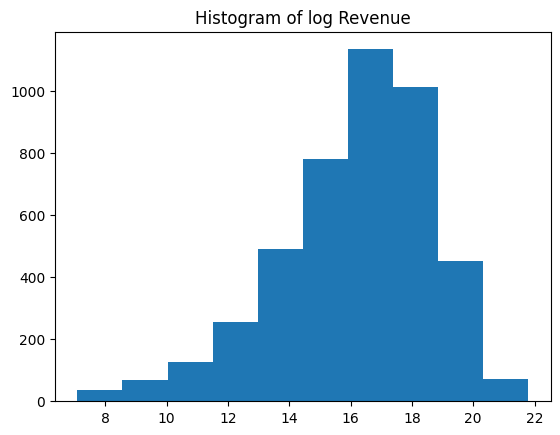

In [25]:
# target transformation
plt.hist(train_movies["revenue"])
plt.title('Histogram of Revenue')
plt.show()

plt.hist(np.log1p(train_movies['revenue']))
plt.title('Histogram of log Revenue')
plt.show()

We can also see that the budget is a high exponential right-skew distribution. We will also graph the log of the budget column.

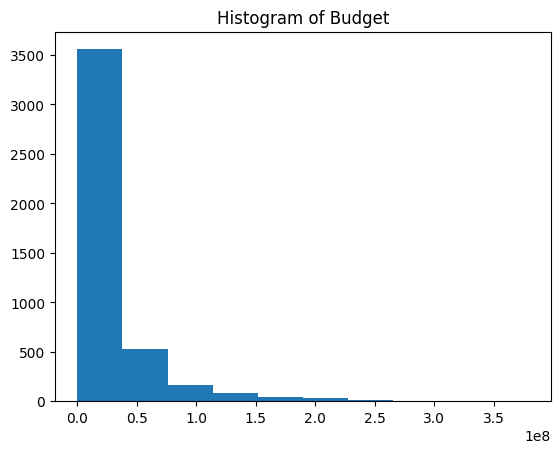

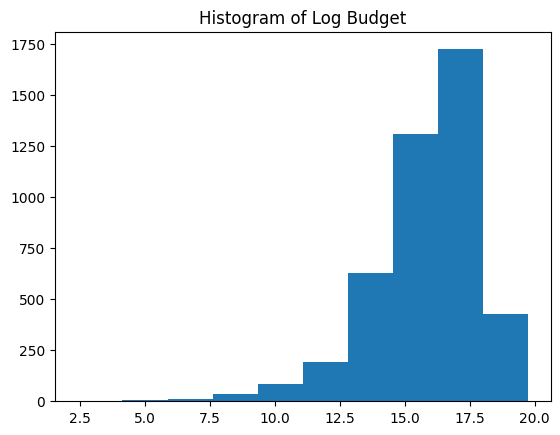

In [26]:
plt.hist(train_movies["budget"])
plt.title('Histogram of Budget')
plt.show()

plt.hist(np.log1p(train_movies['budget']))
plt.title('Histogram of Log Budget')
plt.show()

Let's create a new column for the log revenue values.

In [27]:
train_movies['log_revenue'] = np.log1p(train_movies['revenue'])

# 5. Feature Extraction

## original_language

Let's explore the relationship between language of a film and revenue.

C:\Users\Poomon\AppData\Local\Temp\ipykernel_34196\3762083850.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=filtered_movies, x='original_language', y='revenue', palette='Set1')


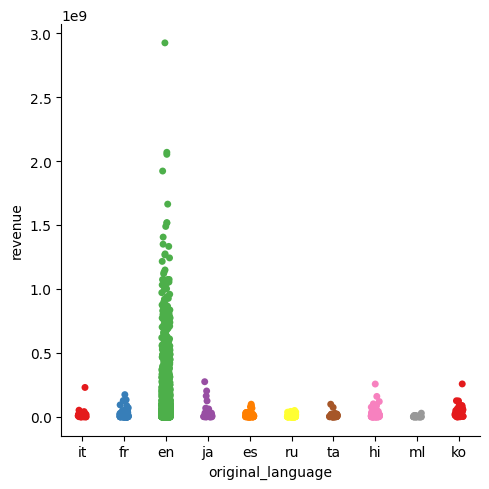

In [28]:
top_ten_languages = train_movies['original_language'].value_counts().head(10)

filtered_movies = train_movies[train_movies['original_language'].isin(top_ten_languages.index)]

sns.catplot(data=filtered_movies, x='original_language', y='revenue', palette='Set1')

 It appears that english language movies generally have higher revenue.

### belong_to_collection

This attribute indicates whether a film is part of a series or franchise. If there is a null value, we will assume that the film is not part of a series.

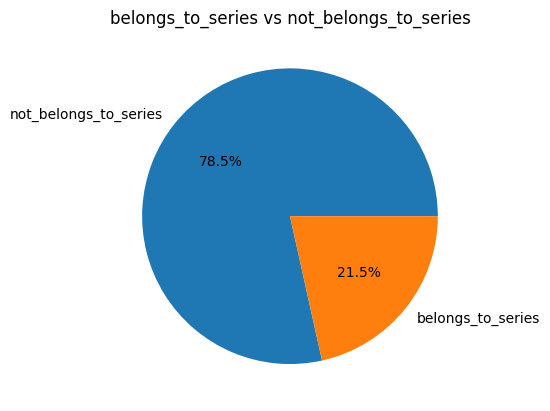

In [29]:
null_count = (train_movies['belongs_to_collection'] == {}).sum()
non_null_count = (train_movies['belongs_to_collection'] != {}).sum()

plt.pie([null_count, non_null_count], labels=['not_belongs_to_series', 'belongs_to_series'], autopct='%1.1f%%')

plt.title('belongs_to_series vs not_belongs_to_series')

plt.show()

The pie chart shows that the majority of the movies do not belongs to series. Only one fifth of them belongs to series.

In [30]:
train_movies['has_collection'] = train_movies['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)
test_movies['has_collection'] = test_movies['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

We can transform 'belongs_to_collection' to a new useful attribute called 'has_collection': a binary type attribute to see if a movie belongs to any collection. Then we add the new column and remove the old one from both training and testing data set.

### genres

We'll get a better idea of what the values for the 'genres' attribute looks like.

In [31]:
for index, row in train_movies.head(5).iterrows():
  print(row['genres'])


[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 9648, 'name': 'Mystery'}, {'id': 18, 'name': 'Drama'}]


Genres is a list of dictionaries, where each dictionary is a genre. We can find out how many genres a movie belongs to by taking the length of this attribute. We will then create a new column containing the number of genres that a film belongs to.

In [32]:
print('Number of genres in films')
train_movies['num_genres'] = train_movies['genres'].apply(lambda x: len(x))
train_movies['num_genres'].value_counts()


Number of genres in films


num_genres
3    1523
2    1440
1     755
4     535
5     148
6      24
7       3
Name: count, dtype: int64

It looks like most movies have 2 or 3 genres associated with them.

In [33]:
# https://www.kaggle.com/code/artgor/eda-feature-engineering-and-model-interpretation
list_of_genres = list(train_movies['genres'].apply(lambda x: [i['name'] for i in x] if len(x) != 0 else []).values)

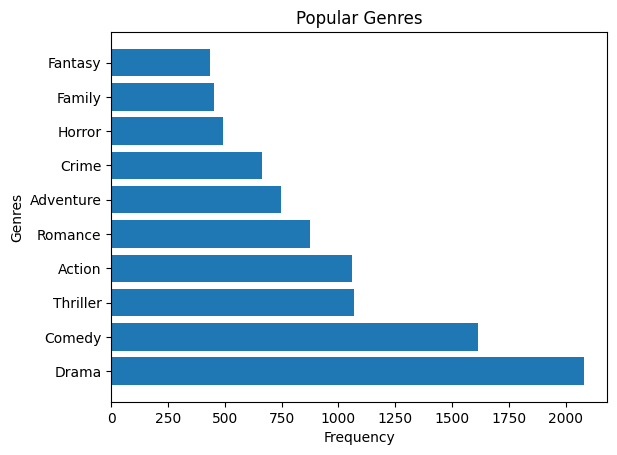

In [34]:
popular_genres = Counter([i for j in list_of_genres for i in j]).most_common(10)
company_names, frequencies = zip(*popular_genres)
plt.barh(range(len(company_names)), frequencies)
plt.yticks(range(len(company_names)), company_names)
plt.xlabel('Frequency')
plt.ylabel('Genres')
plt.title('Popular Genres')
plt.show()

Now let's take a look at whether the number of genres a film has an influence on revenue.

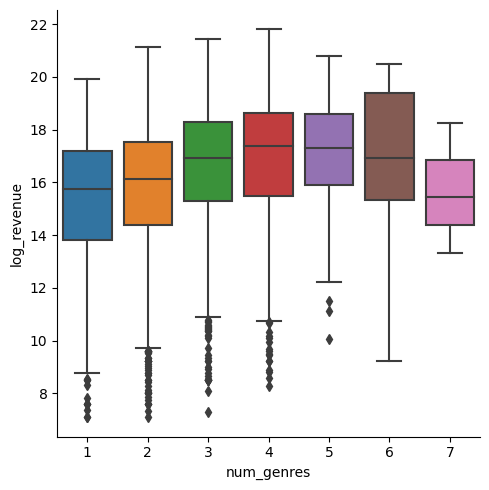

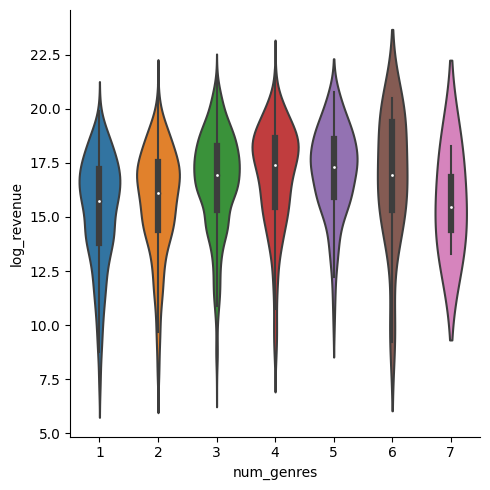

In [35]:
sns.catplot(data=train_movies, x="num_genres", y="log_revenue", kind='box')
sns.catplot(data=train_movies, x="num_genres", y="log_revenue", kind='violin')

It looks like the highest box office films have 3-5 genres, and films that have very few or very many genres tend to have lower revenue. There are also quite a few outliers in the lower range. The data distribution is quite spread out for films with many genres (i.e. > 5).

## 5.1 Feature Extraction from Attributes with Dictionary Values

We will apply the same feature extraction method that we used on genres for the other attributes that contain dictionary objects for their values. The follow code block creates five new columns in the dataset that specifies the number of production companies the movie has, the number of production countries, the number of spoken languages, and the size of the cast and the crew.

In [36]:
list_of_attribs = ['production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew']

for attrib in list_of_attribs:
  col_name = f'num_{attrib}'
  train_movies[col_name] = train_movies[attrib].apply(lambda x: len(x) if isinstance(x, list) else 0)

train_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4428 entries, 212 to 4916
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   belongs_to_collection     4428 non-null   object 
 1   budget                    4428 non-null   int64  
 2   genres                    4428 non-null   object 
 3   original_language         4428 non-null   object 
 4   production_companies      4428 non-null   object 
 5   production_countries      4428 non-null   object 
 6   release_date              4428 non-null   object 
 7   revenue                   4428 non-null   int64  
 8   runtime                   4428 non-null   int64  
 9   spoken_languages          4428 non-null   object 
 10  cast                      4428 non-null   object 
 11  crew                      4428 non-null   object 
 12  original_language_num     4428 non-null   int64  
 13  log_revenue               4428 non-null   float64
 14  has_collect

## production_companies

We will now explore the value counts for production_companies. We'll do a similar analysis to what we did for genre.

C:\Users\Poomon\AppData\Local\Temp\ipykernel_34196\2084494912.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x='num_production_companies', y='revenue', data=train_movies, palette='Set1');


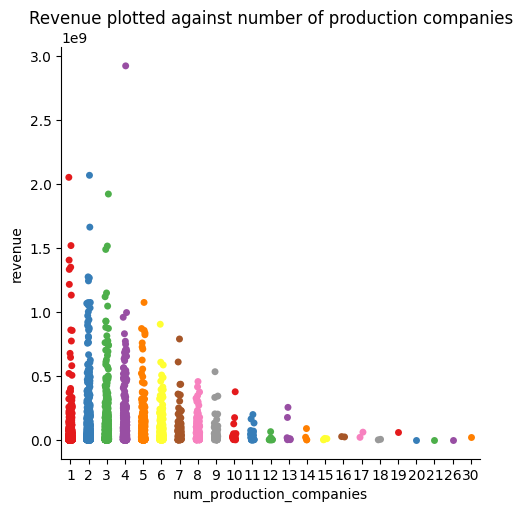

In [37]:
sns.catplot(x='num_production_companies', y='revenue', data=train_movies, palette='Set1');
plt.title('Revenue plotted against number of production companies');

Surprisingly, revenue seems to decrease the more production companies that a film has, although this is likely because there are far fewer films with more than 7 production companies. It looks like films with 1-3 production companies tend to have the highest revenue.

In [38]:
train_movies['num_production_companies'].value_counts()[0:10]

num_production_companies
1     1101
2     1052
3      856
4      514
5      336
6      237
7      103
8       90
9       56
11      26
Name: count, dtype: int64

Most movies have 1-3 production companies, while a few movies have many production companies. We will take a look at the most common production companies.

In [39]:
# https://www.kaggle.com/code/artgor/eda-feature-engineering-and-model-interpretation
list_of_companies = list(movies['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

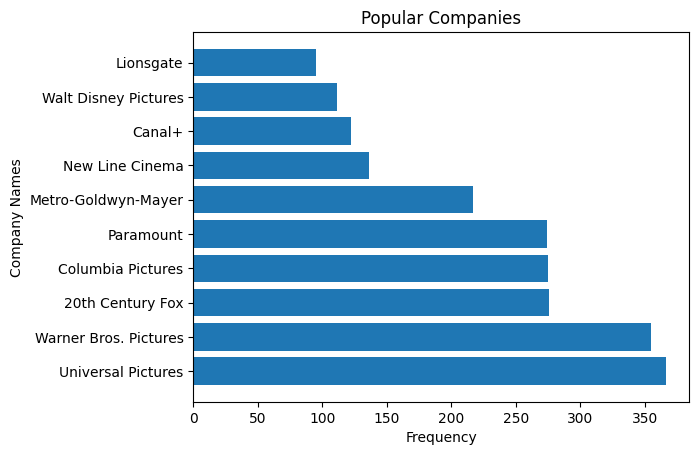

In [40]:
popular_companies = Counter([i for j in list_of_companies for i in j]).most_common(10)
company_names, frequencies = zip(*popular_companies)
plt.barh(range(len(company_names)), frequencies)
plt.yticks(range(len(company_names)), company_names)
plt.xlabel('Frequency')
plt.ylabel('Company Names')
plt.title('Popular Companies')
plt.show()

It appears to be that the top five most popular production companies are Universal Pictures, Warner Bros. Picture, 2oth Century Fox, Columbia Pictures, and Paramount.

## production_countries

We will now explore production_countries and consider other feature extraction methods.

In [41]:
movies['production_countries'].value_counts()

production_countries
[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                                                       2939
[{'iso_3166_1': 'IN', 'name': 'India'}]                                                                                                                                           320
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                        185
[{'iso_3166_1': 'RU', 'name': 'Russia'}]                                                                                                                                          121
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                                                                  112
                                                                     

C:\Users\Poomon\AppData\Local\Temp\ipykernel_34196\3728277316.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x='num_production_countries', y='revenue', data=train_movies, palette='Set1');


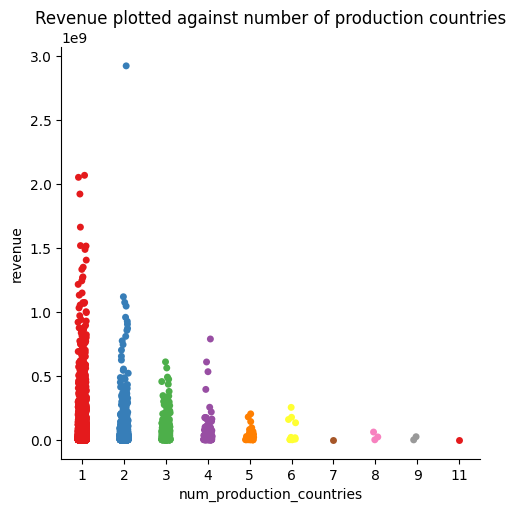

In [42]:
sns.catplot(x='num_production_countries', y='revenue', data=train_movies, palette='Set1');
plt.title('Revenue plotted against number of production countries');

We see that having just one production company tends to have revenue. The more production companies the lower the revenue it seems.

## cast

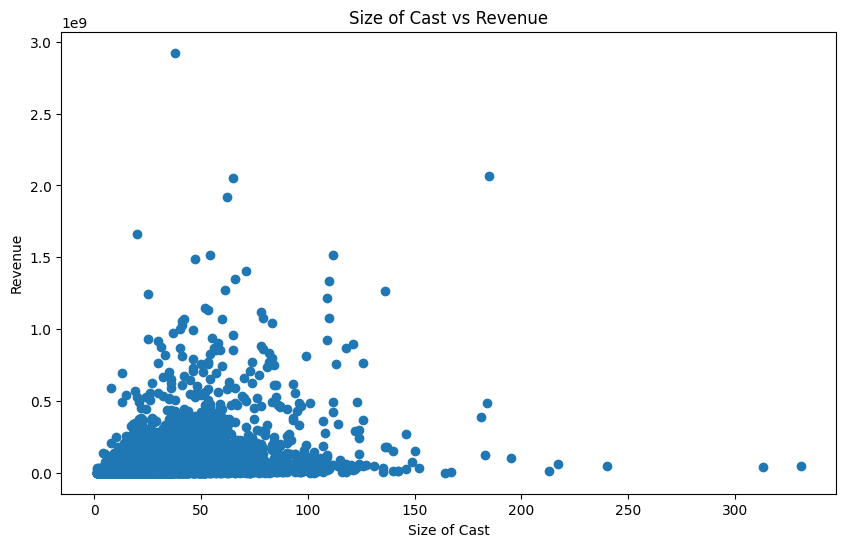

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_movies['num_cast'], train_movies['revenue'])
plt.xlabel('Size of Cast')
plt.ylabel('Revenue')
plt.title('Size of Cast vs Revenue')
plt.show()


By calculating the correlation we can see that there is a weak-moderate relationship between the size of the cast and the film's revenue.

In [44]:
correlation = train_movies['num_cast'].corr(train_movies['revenue'])
print("Correlation between Cast Size and Revenue:", correlation)


Correlation between Cast Size and Revenue: 0.31707809524670905


## crew

We will apply the same analysis to crew.

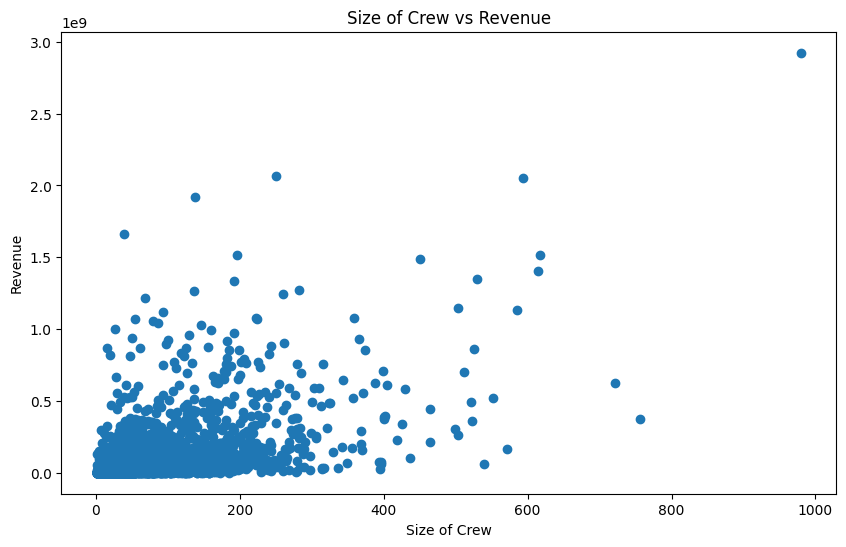

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_movies['num_crew'], train_movies['revenue'])
plt.xlabel('Size of Crew')
plt.ylabel('Revenue')
plt.title('Size of Crew vs Revenue')
plt.show()


Just as we did with the size of the cast, let's calculate the correlation coefficient.

In [46]:
correlation = train_movies['num_crew'].corr(train_movies['revenue'])
print("Correlation between Crew Size and Revenue:", correlation)


Correlation between Crew Size and Revenue: 0.5552529678132251


The correlation between the size of the crew and revenue is stronger than that of size of the cast and revenue.

## release_date

We will want to extract the release date into useful attributes for our model. First let's create some columns that represent the release year, month, and day.

In [47]:
def parse_date(date_str):
  year, month, day = map(int, date_str.split('-'))
  date_dict = {
      'year': year,
      'month': month,
      'day': day
  }
  return date_dict



In [48]:
date_strings = ['year', 'month', 'day']
for s in date_strings:
    train_movies.loc[:, f'release_{s}'] = train_movies.loc[:, 'release_date'].apply(lambda x: parse_date(x)[s])

Now that we have these columns we will plot dates against revenue.

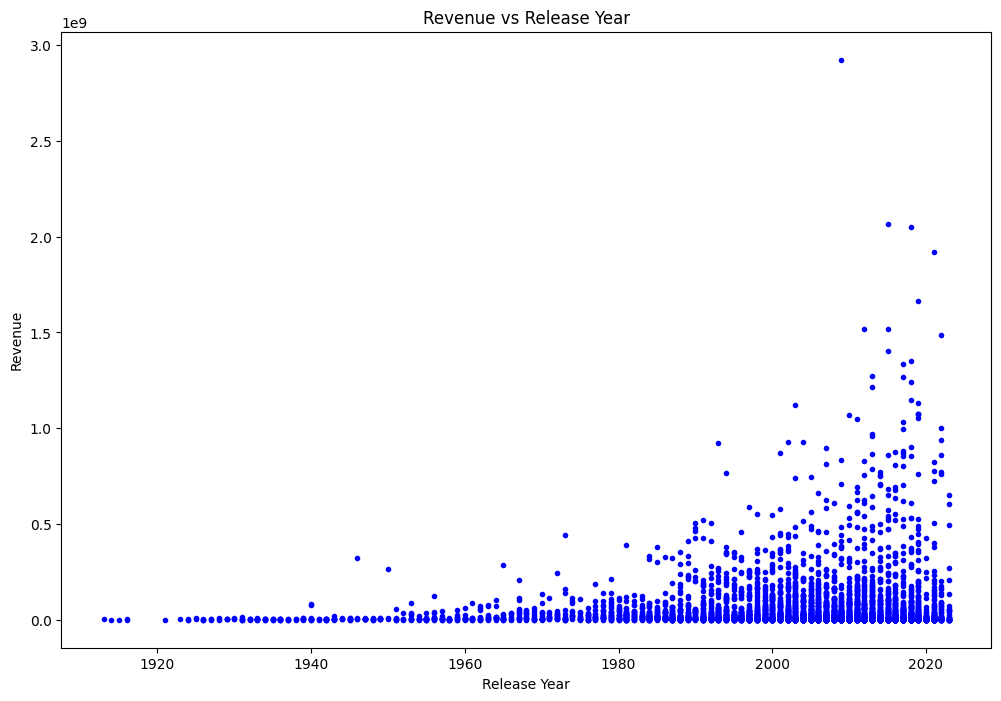

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.plot(train_movies['release_year'], train_movies['revenue'], 'b.')
plt.xlabel('Release Year')
plt.ylabel('Revenue')
plt.title('Revenue vs Release Year')
plt.show()


It looks like revenue generally increases the more recent the film is. This would make sense because the values are not adjusted for inflation. Let's compare the release year and budget.

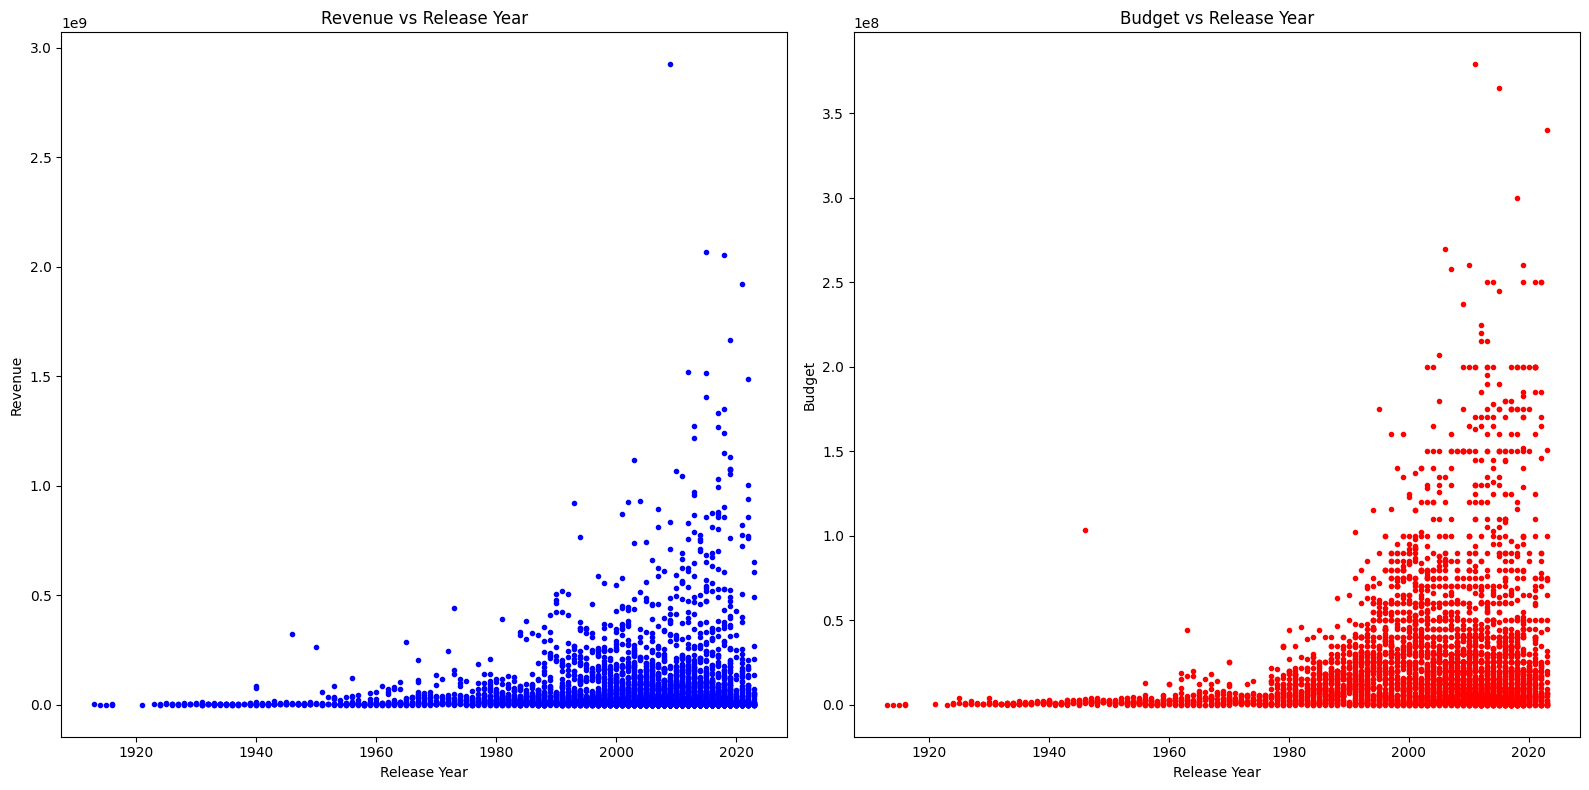

In [50]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(train_movies['release_year'], train_movies['revenue'], 'b.')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Revenue')
axes[0].set_title('Revenue vs Release Year')

axes[1].plot(train_movies['release_year'], train_movies['budget'], 'r.')
axes[1].set_xlabel('Release Year')
axes[1].set_ylabel('Budget')
axes[1].set_title('Budget vs Release Year')

plt.tight_layout()
plt.show()


We can see here that budget follows a similar trend to revenue.

Let's plot revenue against the release month.

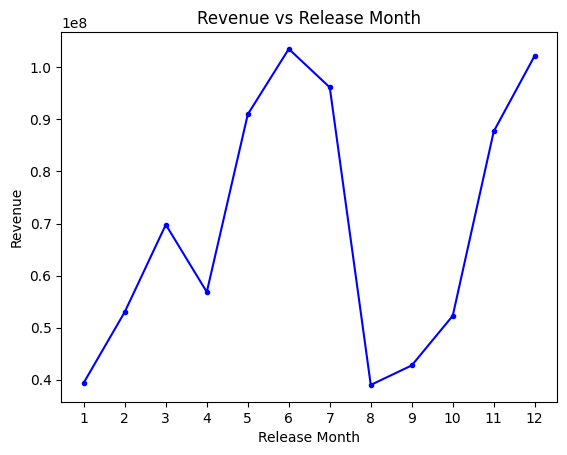

In [51]:
revenue_by_month = train_movies.groupby('release_month')['revenue'].mean()

plt.plot(revenue_by_month.index, revenue_by_month.values, 'b.-')
plt.xlabel('Release Month')
plt.ylabel('Revenue')
plt.title('Revenue vs Release Month')
plt.xticks(range(1, 13))
plt.show()


It looks like the months with the highest revenue tend to be in the summer and in the winter. This makes sense since both are holiday seasons and typically large blockbuster films are released in these time periods.

Now let's consider release day.

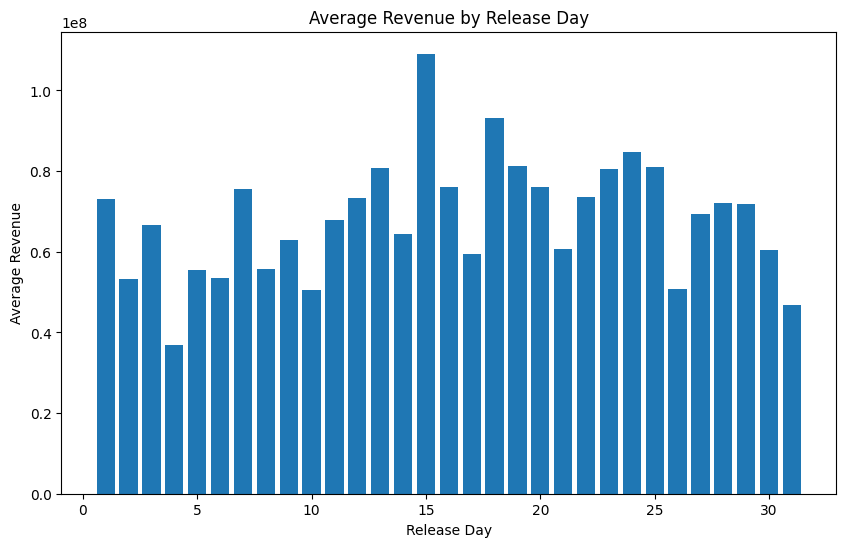

In [52]:
import matplotlib.pyplot as plt

avg_revenue_by_day = train_movies.groupby('release_day')['revenue'].mean()

plt.figure(figsize=(10, 6))
plt.bar(avg_revenue_by_day.index, avg_revenue_by_day.values)
plt.xlabel('Release Day')
plt.ylabel('Average Revenue')
plt.title('Average Revenue by Release Day')
plt.show()


There doesn't seem to be much of an underlying pattern here. We will discard this column and clean up all the unnecessay columns from the training dataset now that feature extraction has completed.

In [53]:
# drop all the columns that we don't need from dict_col
dict_col = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages','release_day',  'cast', 'crew', 'release_date', 'original_language']
train_movies.drop(dict_col, axis=1, inplace=True)

<Axes: >

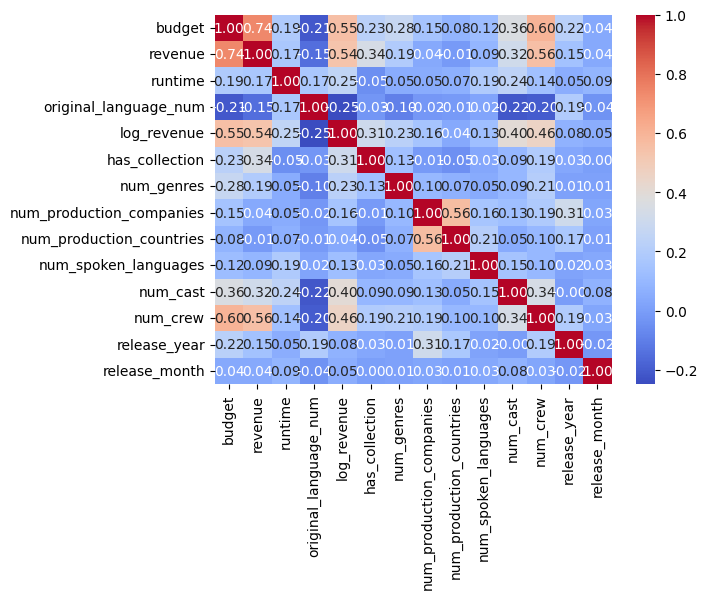

In [54]:
c = train_movies.corr()
sns.heatmap(c, cmap='coolwarm', annot=True, fmt=".2f")

# Apply Changes to Test Set

We must do the same clean up for the unnecessay columns from the testing dataset.

In [55]:
test_movies = test_movies.reset_index(drop=True)

test_movies['num_genres'] = test_movies['genres'].apply(lambda x: len(x))
for attrib in list_of_attribs:
  col_name = f'num_{attrib}'
  test_movies[col_name] = test_movies[attrib].apply(lambda x: len(x) if isinstance(x, list) else 0)
for s in date_strings:
    test_movies.loc[:, f'release_{s}'] = test_movies.loc[:, 'release_date'].apply(lambda x: parse_date(x)[s])

test_movies.drop(dict_col, axis=1, inplace=True)

In [56]:
test_movies = test_movies.reset_index(drop=True)

In [57]:
train_movies.drop('log_revenue', axis=1, inplace=True)

In [58]:
# Confirm the shape of the data is the same for test and train set
print(test_movies.shape)
print(train_movies.shape)

(1108, 13)
(4428, 13)


# 6. Create Pipeline and Select Models

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = ["runtime",
"num_genres",
"num_production_companies",
"num_production_countries",
"num_spoken_languages",
"num_cast",
"num_crew"]

cat_attribs = [
"release_month",
"has_collection"
]

log_attribs = ["budget"]

log_transform = FunctionTransformer(func=np.log1p, feature_names_out="one-to-one", inverse_func=np.expm1)

num_pipeline = make_pipeline(StandardScaler())

cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown="ignore")
)

log_pipeline = make_pipeline(log_transform, StandardScaler())

preprocessing = ColumnTransformer([
    ("log", log_pipeline, log_attribs),
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
    ], remainder='passthrough')

We have developed three distinct pipelines: "log," "num," and "cat." The "log" pipeline applies Logarithm and StandardScaler techniques to normalize the exponentially large values of the Budget feature. The "num" pipeline exclusively employs StandardScaler to resize the distributions of other non-exponential numerical attributes. Finally, the "cat" pipeline incorporates one-hot encoding and StandardScaler to handle categorical attributes, including release_month and has_collection, effectively preparing them for integration into our learning models.

# Selecting and Training Models

Given the large values for the revenue data, we will make our predictions on the logarithm of the revenue values. Since the values for revenue are so large, we are more interested in predicting the order of magnitude of the revenue.

In [60]:
X = train_movies.drop(['revenue'], axis=1)
y = np.log1p(train_movies['revenue'])

## Linear Regression

We saw that there were a few strong linear relationships between features and our target variable. We will first consider how Linear Regression performs.

In [61]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

lin_reg.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['budget']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['runtime', 'num_genres',
                                                   'num_production_companies',
                                                   'num_production_countries',
                                                   'num_spoken_languages',
                                                   'num_cast', 'num_crew']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['release_month',
                                                   'has_collection'])])),
                ('linearregression', LinearRegression())])

In [62]:
from sklearn.metrics import mean_squared_error
movies_pred = lin_reg.predict(X)

lin_rmse_train = mean_squared_error(movies_pred, y ,squared=False)
lin_rmse_train

1.5928934452996388

The linear regression model seems to perform quite well. A RMSE score of 1.59 indicates that our prediction deviates from the true log revenue values by 1.59 units.

In [63]:
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg,X,y,
  scoring="neg_root_mean_squared_error",
  cv=10
)
lin_mean_rmse = np.mean(lin_rmses)
lin_mean_rmse

1.6012055989888083

Evaluate our linear regression model using cross-validation to assess its performance. The data is divided into 10 folds, and the model is trained and evaluated 10 times, with each fold serving as the validation set. Calculate the RMSE for each iteration and return the mean of the 10 RMSE values. We obtains similar score which is 1.60 units.

## Decision Tree

In [64]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

tree_reg.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['budget']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['runtime', 'num_genres',
                                                   'num_production_companies',
                                                   'num_production_countries',
                                                   'num_spoken_languages',
                                                   'num_cast', 'num_crew']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['release_month',
                                                   'has_collection'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [65]:
y_pred = tree_reg.predict(X)
tree_rmse_train = mean_squared_error(y,y_pred,squared=False)
tree_rmse_train

4.623672167761526e-17

Given this low error nearly 0, it seems likely that we are overfitting, we will evaluate using cross validation.

In [66]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg,X,y,
  scoring="neg_root_mean_squared_error",
  cv=10
)
tree_mean_rmse = np.mean(tree_rmses)
tree_mean_rmse

2.181464949688232

Let try evaluating our linear regression model using the same cross-validation technique as aboved model to see if we can avoid overfitting. The data is divided into 10 folds, and the model is trained and evaluated 10 times. Now, we obtain 2.18 which is clearly not overfitiing, but the RMSE is higher than the linear regression model.

## Random Forest

In [67]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_reg.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['budget']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['runtime', 'num_genres',
                                                   'num_production_companies',
                                                   'num_production_countries',
                                                   'num_spoken_languages',
                                                   'num_cast', 'num_crew']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['release_month',
                                                   'has_collection'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [68]:
y_pred = forest_reg.predict(X)
forest_rmse_train = mean_squared_error(y,y_pred,squared=False)
forest_rmse_train

0.577326478885933

In [69]:
from sklearn.model_selection import cross_val_score

forest_rmses = -cross_val_score(forest_reg,X,y,
  scoring="neg_root_mean_squared_error",
  cv=10
)
forest_mean_rmse = np.mean(forest_rmses)
forest_mean_rmse

1.5567822002026657

Random Forest performs slightly better than linear regression with only 0.58 units of RMSE. However, the cross validation technique, evaluating RMSE 10 times, the RMSE increases to 1.56. However, it is still the lowest PMSE thus far. We will now consider some hyper parameter tuning.

## Random Forest Hyper Parameter Tuning

### Grid Search

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("random_forest",RandomForestRegressor(random_state=42)),
])

param_grid = [
{'random_forest__n_estimators': [3, 10, 30], 'random_forest__max_features': [2, 4, 6, 8]},
{'random_forest__bootstrap': [False], 'random_forest__n_estimators': [3, 10],'random_forest__max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(full_pipeline,
                           param_grid,
                           cv=10,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['budget']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardsc...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['release_month',
                                                                          'has_collection'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [2, 4, 6, 8],
                          'random_forest__n_estimators': [3, 10, 30]},
                         {'random_forest__bootstrap': [False],
                          'random_forest__max_features': [2, 3, 4],
                          'random_forest__n_estimators': [3, 10]}],
             scoring='neg_root_mean_squared_error')

In [71]:
best_params = grid_search.best_params_
best_params

{'random_forest__max_features': 6, 'random_forest__n_estimators': 30}

In [72]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head(5)["mean_test_score"]

8    -1.56
11   -1.56
5    -1.59
7    -1.61
10   -1.62
Name: mean_test_score, dtype: float64

This did not improve our error.

### Randomized Search

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

full_pipeline = Pipeline([
  ("preprocessing", preprocessing),
  ("random_forest",RandomForestRegressor(random_state=42)),
])

param_distribs = {'random_forest__max_features': randint(low=2,high=20)}

rnd_search = RandomizedSearchCV(full_pipeline,
  param_distributions=param_distribs,
  n_iter=10,
  cv=10,
  scoring='neg_root_mean_squared_error',
  random_state=42
)

rnd_search.fit(X, y)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log1p'>,
                                                                                                                    inverse_func=<ufunc 'expm1'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['budget']),
                                                                              ('num',
                                                                               Pipeline(steps=[('stan...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['release_month',
                                                                                'has_collection'])])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021D5BEF4B50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [74]:
rn_res = pd.DataFrame(rnd_search.cv_results_)
rn_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
rn_res.head(5)["mean_test_score"]

0   -1.54
4   -1.54
2   -1.54
5   -1.54
6   -1.54
Name: mean_test_score, dtype: float64

Randomized search marginally improved our error.

## XGB Regressor

In [75]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(X, y)
xgb_pred = xgb_reg.predict(X)

xgb_rmse_train = mean_squared_error(y, xgb_pred, squared=False)
xgb_rmse_train

0.6899635023837887

XGBRegressor with cross validation.

In [76]:
xgb_rmses = -cross_val_score(xgb_reg,X,y,
  scoring="neg_root_mean_squared_error",
  cv=10
)
xgb_mean_rmse = np.mean(xgb_rmses)
xgb_mean_rmse

1.627502735980627

Similar to the Random Forest model, a single RMSE score is as low as 0.69 units. However, with cress validation, evaluating RMSE score 10 times, the score jumps to 1.62 units.

<Axes: >

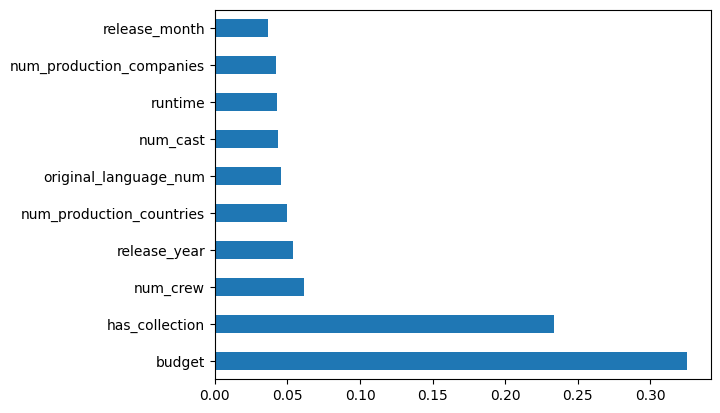

In [77]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

The bar chart provides an overview of the feature scores in our model, reflecting their relative importance. As anticipated, the Budget feature emerges as the most influential factor in our predictions, affirming our initial assumption. Surprisingly, we also found that the has_collection, indicating a movie belonging to a series, holds significant importance, ranking as the second most influential attribute in our model. Furthermore, factors like num_crew, release_year, num_production_counties, among others, contribute to the decision-making process of our model predictions.

# Evaluating on the Test Set using Random Forest

On cross validation, it seems that the random forest model performed the best. We've already performed some hyperparameter tuning and saw that it performed fairly well. We are now ready to make predictions on the test set using linear regression, decision tree, random forest, random forest (tuned), and XGB regressor.

In [78]:
X_test = test_movies.drop("revenue", axis=1)
y_test = np.log1p(test_movies["revenue"]).copy()

forest_tuned_model = rnd_search.best_estimator_
forest_model = forest_reg
tree_model = tree_reg
lin_model = lin_reg
xgb_model = xgb_reg

forest_tuned_predictions = forest_tuned_model.predict(X_test)
forest_tuned_rmse_final = mean_squared_error(y_test, forest_tuned_predictions, squared=False)

forest_predictions = forest_model.predict(X_test)
forest_rmse_final = mean_squared_error(y_test, forest_predictions, squared=False)

tree_predictions = tree_model.predict(X_test)
tree_rmse_final = mean_squared_error(y_test, tree_predictions, squared=False)

xgb_predictions = xgb_model.predict(X_test)
xgb_rmse_final = mean_squared_error(y_test, xgb_predictions, squared=False)

lin_predictions = lin_model.predict(X_test)
lin_rmse_final = mean_squared_error(y_test, lin_predictions, squared=False)

In [79]:
print(lin_rmse_train, lin_mean_rmse, lin_rmse_final)
print(tree_rmse_train, tree_mean_rmse, tree_rmse_final)
print(forest_rmse_train, forest_mean_rmse, forest_rmse_final)
print(forest_tuned_rmse_final)
print(xgb_rmse_train, xgb_mean_rmse, xgb_rmse_final)

1.5928934452996388 1.6012055989888083 1.593836762261383
4.623672167761526e-17 2.181464949688232 2.2463115584408486
0.577326478885933 1.5567822002026657 1.573222321068187
1.5419508168319778
0.6899635023837887 1.627502735980627 1.6290660531640662


# Conclusion

We collected data using TMDB's free API. Of the nearly 10,000 data points we collected we pruned about half of them to filter out instances with missing or invalid data.

Feature extraction was performed on these attributes to be used for our models. Primarily this consisted of finding the number of associated genres, production companies and countries, and the size of the cast and crew. We also converted some attributes into categorical columns such as the original language feature. Further feature selection could be performed to create one hot encodings of the most popular genres, production companies, or cast and crew members. We decided to keep our model simple and determined that further feature extraction was beyond the scope of this project.

Our initial assumption regarding the strong correlation between budget and box office revenue has been confirmed. Additionally, our analysis revealed that the has_collection attribute serves as another important contributor to predicte box office revenue. Moreover, factors such as num_crew, release_year, and others were found to make smaller yet noticeable contributions to the prediction.

The training set was evaluated using models such as linear regression, decision tree, random forest, and XGB regressor. From table 1, it was clearly visible that random forest performed the best on the training set since it has the lowest RMSE and cross validation score. From table 2, we can observe that random forest (tuned version) performed the best on the testing set since it has the lowest RMSE score among all the models. The RMSE score for random forest (tuned) came out to be 1.55 which indicates that our prediction deviates from the true log revenue values by 1.55 units.

Therefore, random forest was the best model for predicting box office revenue given the TMDB data set.

**Table 1: Model and its RMSE (training set)**

| Model | RMSE | Mean RMSE (Cross Validation)
| ----- | ---- | --------- |
| Linear Regression | 1.5928934452996388 | 1.6012055989888083
| Decision Tree | 4.623672167761526e-17 | 2.1763940639259083
| Random Forest | 0.5783567655082242 | 1.5572903725223233
| XGB Regressor | 0.6899635023837887 | 1.627502735980627


**Table 2: Model and its RMSE (testing set)**

| Model | RMSE |
| ----- | ---- |
| Linear Regression | 1.5938367622613832
| Decision Tree | 2.2386676620513346
| Random Forest | 1.5729142560234277
| Random Forest (Tuned) | 1.5531069106379856
| XGB Regressor | 1.6290660531640662

This information could be valuable to investors and production companies when considering greenlighting film projects. With more data and more features such as marketing budget and other data that is internal to film studios, it is likely that a similar model could be improved.

Some things we could do to improve our score would be to consider further feature extraction. For example, we could provide one hot encoding on the top genres, production companies, cast members and crew members. If there is an association with these values with revenue this would likely improve the predictive power of our model. A larger and more complete dataset would also be helpful for future projects.


There are also a few limitations of the data collected.

# Limitations

There are a few limitations with the dataset that we acquired. Budget and revenue information is manually entered by users so the data might not accurately reflect the true values of the film's budget and box office performance. Additionally, this data likely only exists for popular films because users are more likely to enter information for popular movies or movies that they like. The values are also not adjusted for inflation, so the values are not given equal weight because more recent films will have higher revenue due to inflation.

# References

Data was collected using TMDB's free API:

[1] “The Movie Database TMDB”, 2023. Available: https://www.themoviedb.org/. Accessed: 06 June 2023.

Feature explanations given by TMDB:

[2] “Movie Bible - Primary Facts - The Movie Database TMDB”, 2023. Available: https://www.themoviedb.org/bible/movie/59f3b16d9251414f20000001#59f73b759251416e71000005. Accessed: 06 June 2023.


We found a similar dataset on kaggle.com using data gathered from TMDB.

[3] “TMDB Box Office Prediction”, 2023. Available: https://www.kaggle.com/competitions/tmdb-box-office-prediction/overview. Accessed: 09 June 2023.

In particular we drew influence from the following code submissions, mainly for feature extraction.

[4] A. Luckynnenko, “EDA, Feature Engineering and model interpretation”, 2023. Available: https://www.kaggle.com/code/artgor/eda-feature-engineering-and-model-interpretation. Accessed: 12 June 2023.

[5] S, Tavoosi, “Predicting box office revenue with Random Forest”, 2023. Available: https://www.kaggle.com/code/tavoosi/predicting-box-office-revenue-with-random-forest. Accessed: 12 June 2023.

Addition learning resources and documents for used libaries:

[6] "Python Packages Introduction - xgbboot 2.0.0", 2023. Available: https://xgboost.readthedocs.io/en/latest/python/python_intro.html. Accessed: 12 June 2023.

[7] "Scikit-learn: Machine Learning in Python", 2023. Available: https://scikit-learn.org/stable/. Access: 12 June 2023.

We also borrowed code from the textbook and adapted some of it to suit our use case:

[8] A. G. O'Reilly, "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", 2023, Access: 12 June 2023.
